# Notebook Imports

In [1]:
from os import walk
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from collections import Counter
from wordcloud import WordCloud
from PIL import Image

from sklearn.model_selection import train_test_split

%matplotlib inline

# Costants

In [2]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_NO = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/emails-json-data.json'
WORD_VOCAB_FILE = 'SpamData/01_Processing/word-by-id.csv'
TRAIN_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'


THUMB_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMB_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
FONT_FILE = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

# Reading File

In [3]:
with open(EXAMPLE_FILE, encoding='latin-1') as file:
    email = file.read()
print(email)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [4]:
# checking the system encoding system
import sys
sys.getfilesystemencoding()

'utf-8'

In [5]:
# fetching only the body of email
with open(EXAMPLE_FILE, encoding='latin-1') as file:
    is_body = False
    lines = []
    for line in file:
        if is_body:
            lines.append(line)
        elif line == '\n':
            is_body = True
 
email = '\n'.join(lines)
print(email)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator functions

In [6]:
def generate_squares(N):
    """ Generator functions keep the memory of the previouse results """
    for number in range(N + 1):
        yield number ** 2

In [7]:
generate_squares(6)

<generator object generate_squares at 0x000001DC3FCC77B0>

In [8]:
for i in generate_squares(6):
    print(i, end='->')

0->1->4->9->16->25->36->

# Extracting body of all Emails

In [9]:
def email_body_generator(path):
    """ Generator function which walk throug each email and return back the file 
    name and email body for each email in the file path provided"""
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            filepath = join(root, file_name)
            with open(filepath, encoding='latin-1') as file:
                is_body = False
                lines = []
                for line in file:
                    if is_body:
                        lines.append(line)
                    elif line == '\n':
                        is_body = True

            email = '\n'.join(lines)
            yield file_name, email

In [10]:
def dataframe_from_directory(path, classfication):
    """ Function which return Dataframe of all email bodies with their respective names """
    row = []
    row_names = []
    for file_name, email in email_body_generator(path):
        row.append({'MESSAGE': email, 'CATEGORY': classfication})
        row_names.append(file_name)
    return pd.DataFrame(row, index=row_names)

In [11]:
# calling the function to craete spam email dataframe
spam_emails = pd.concat([dataframe_from_directory(SPAM_1_PATH, SPAM_CAT), dataframe_from_directory(SPAM_2_PATH, SPAM_CAT)])
spam_emails.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [12]:
spam_emails.shape

(1898, 2)

In [13]:
# calling the function to craete non-spam email dataframe
non_spam_emails = pd.concat([dataframe_from_directory(EASY_SPAM_1_PATH, HAM_CAT), dataframe_from_directory(EASY_SPAM_2_PATH, HAM_CAT)])
non_spam_emails.head()

,MESSAGE,CATEGORY
00001.7c53336b37003a9286aba55d2945844c,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
00002.9c4069e25e1ef370c078db7ee85ff9ac,"Martin A posted:\n\nTassos Papadopoulos, the G...",0
00003.860e3c3cee1b42ead714c5c874fe25f7,Man Threatens Explosion In Moscow \n\n\n\nThur...,0
00004.864220c5b6930b209cc287c361c99af1,Klez: The Virus That Won't Die\n\n \n\nAlready...,0
00005.bf27cdeaf0b8c4647ecd61b1d09da613,"> in adding cream to spaghetti carbonara, whi...",0


In [14]:
non_spam_emails.shape

(3901, 2)

In [15]:
dataset = pd.concat([spam_emails, non_spam_emails]) # Joining all emails to have a single dataset

In [16]:
dataset.shape

(5799, 2)

# Data Cleaning: Checking for missing (null or empty) values

## Removing null emails

In [17]:
# checking if there is null email
dataset.MESSAGE.isnull().values.any()

False

In [18]:
# checking if there is empty email
empty = dataset.MESSAGE.str.len() == 0
print(empty.any()) # check if empty email exist
empty.sum() # return total number of empty emails

True


3

In [19]:
# function to check number of entries with null or empty values
def check_for_null_empty_emails(data):
    null_emails = data.MESSAGE.isnull().values.sum()
    empty_emails = (data.MESSAGE.str.len() == 0).sum()
    return f'{null_emails} Null Emails : {empty_emails} Empty Emails'

In [20]:
# calling the function to check empty and null emails
check_for_null_empty_emails(data=dataset)

'0 Null Emails : 3 Empty Emails'

In [21]:
# locate the emmpty emails
dataset[empty].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [22]:
dataset.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

## Removing all empty emails

In [23]:
dataset.drop(['cmds',], inplace=True)

In [24]:
# calling the function to check empty emails
check_for_null_empty_emails(data=dataset)

'0 Null Emails : 0 Empty Emails'

In [25]:
dataset.shape

(5796, 2)

# Add Document IDs to track Emails in Dataframe

In [26]:
document_ids = range(0, len(dataset.index))
document_ids

range(0, 5796)

In [27]:
dataset['DOC_ID'] = document_ids
dataset['FILE_NAME'] = dataset.index
dataset.set_index('DOC_ID', inplace=True)

In [28]:
dataset

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d
...,...,...,...
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676


# Save the cleaned dataset

In [29]:
dataset.to_json(DATA_JSON_FILE)

# Data Visualization

## Spam Vs Non-spam emails (pie chart)

In [30]:
dataset.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [31]:
amount_of_spam_emails = dataset.CATEGORY.value_counts()[1]
amount_of_non_spam_emails = dataset.CATEGORY.value_counts()[0]

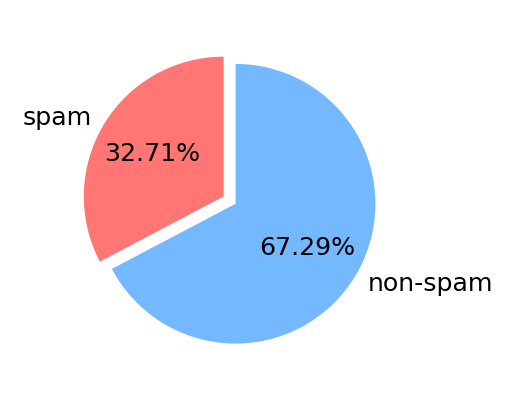

In [32]:
category_names = ['spam', 'non-spam']
sizes = [amount_of_spam_emails, amount_of_non_spam_emails]

plt.figure(figsize=[2, 2], dpi=227)
plt.pie(sizes, labels=category_names, startangle=90, autopct='%1.2f%%', textprops={'fontsize': 8,},
       colors=['#ff7675', '#74b9ff'], explode=[0, 0.1])
plt.show()

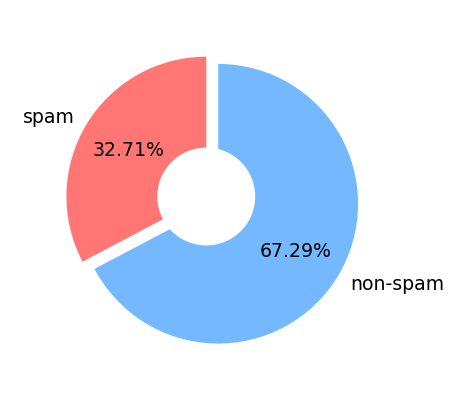

In [33]:
category_names = ['spam', 'non-spam']
sizes = [amount_of_spam_emails, amount_of_non_spam_emails]

plt.figure(figsize=[2, 2], dpi=227)
plt.pie(sizes, labels=category_names, startangle=90, autopct='%1.2f%%', textprops={'fontsize': 6,},
       colors=['#ff7675', '#74b9ff'], explode=[0, 0.1], pctdistance=0.65)

# Creating a dona chart
# Add a circle athe center of the pie chart
circle = plt.Circle((0,0), radius=0.35, fc='white')
plt.gca().add_artist(circle)

plt.show()

# Natual Language Processing
## Text Pre-processing

In [34]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

### Tokenising

In [35]:
msg = 'All work and no play makes Jack a dull boy. No one like him!.'
word_tokenize(msg.lower())

['all',
 'work',
 'and',
 'no',
 'play',
 'makes',
 'jack',
 'a',
 'dull',
 'boy',
 '.',
 'no',
 'one',
 'like',
 'him',
 '!',
 '.']

### Removing StopWords

In [36]:
stop_words = set(stopwords.words('english'))  # set is convinient more than list
filtered_words = [word for word in word_tokenize(msg.lower()) if word not in stop_words]
filtered_words

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', 'one', 'like', '!', '.']

### Word Stems and Stemming

In [37]:
stemmer = PorterStemmer()
stemmed_words = [stemmer.stem(word) for word in word_tokenize(msg.lower()) if word not in stop_words]
stemmed_words

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', 'one', 'like', '!', '.']

### Removing Punctuations

In [38]:
stemmer = PorterStemmer()
stemmed_words = [stemmer.stem(word) for word in word_tokenize(msg.lower()) if (word not in stop_words and word.isalpha())]
stemmed_words

['work', 'play', 'make', 'jack', 'dull', 'boy', 'one', 'like']

### Removing HTML tags

In [39]:
soup = BeautifulSoup(dataset.at[0, 'MESSAGE'])
print(soup.prettify())

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">
<html>
 <head>
  <meta charset="utf-8" content='3D"text/html;' http-equiv="3DContent-T=" ype=""/>
  <meta content='3D"MSHTML' name="3DGENERATOR"/>
 </head>
 <body>
  <!-- Inserted by Calypso -->
  <table black="" border="3D0" cellpadding="3D0" cellspacing="3D2" display:="" id="3D_CalyPrintHeader_" none="" r="ules=3Dnone" style='3D"COLOR:' width='3D"100%"'>
   <tbody>
    <tr>
     <td colspan="3D3">
      <hr color="3Dblack" noshade="" size="3D1"/>
     </td>
    </tr>
    <tr>
     <td colspan="3D3">
      <hr color="3Dblack" noshade="" size="3D1"/>
     </td>
    </tr>
   </tbody>
  </table>
  <!-- End Calypso -->
  <!-- Inserted by Calypso=

 -->
  <font color="3D#000000" face="3DVERDANA,ARIAL,HELVETICA" size="3D-2">
   <br/>
  </font>
  &lt;=

/TR&gt;
  <!-- End Calypso -->
  <font bold="" color="3D#ff0000" face='3D"Copperplate' gothic="" ptsize='3D"10"' size="3D5">
  </font>
  <center>
   Save up to 70% on Life Insuran

In [40]:
soup.get_text() # remove all html tags and return a clear text

"\n\n\n\n\n\n\n\n\n\n\n\n\n<=\n\n/TR>\nSave up to 70% on Life Insurance.\nWhy Spend More Than You Have To?\n\n\nLife Quote Savings\n\n\n\n\n\n\n\n\n\n\n\nEnsurin=\n\ng your \n\n      family's financial security is very important. Life Quote Savings ma=\n\nkes \n\n      buying life insurance simple and affordable. We Provide FREE Access =\n\nto The \n\n      Very Best Companies and The Lowest Rates.\n\n\n\n\n\nLife Quote Savings is FAST, EAS=\n\nY and \n\n            SAVES you money! Let us help you get started with the best val=\n\nues in \n\n            the country on new coverage. You can SAVE hundreds or even tho=\n\nusands \n\n            of dollars by requesting a FREE quote from Lifequote Savings. =\n\nOur \n\n            service will take you less than 5 minutes to complete. Shop an=\n\nd \n\n            compare. SAVE up to 70% on all types of Life insurance! \n\n\n\n\nClick Here For Your=\n\n \n\n            Free Quote!\n\nProtecting your family is the best investment you'll ev

## Function to clean email

In [41]:
def clean_emails(message, stemmer = PorterStemmer(), stop_words = set(stopwords.words('english'))):
    # removing HTML tags
    soup = BeautifulSoup(message)
    message_without_html = soup.get_text()
    # splits the entire message to individual words (tokens)
    tokens = word_tokenize(message_without_html.lower())
    
    # stemming tokens and removing all puntuations
    filtered_words = [stemmer.stem(word) for word in tokens if word not in stop_words and word.isalpha()]
    return filtered_words

### Accessing individual data from the dataset

In [42]:
clean_emails(dataset.at[0, 'MESSAGE'])

['save',
 'life',
 'insur',
 'spend',
 'life',
 'quot',
 'save',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'rate',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',
 'us',
 'help',
 'get',
 'start',
 'best',
 'ue',
 'countri',
 'new',
 'coverag',
 'save',
 'hundr',
 'even',
 'usand',
 'dollar',
 'request',
 'free',
 'quot',
 'lifequot',
 'save',
 'servic',
 'take',
 'less',
 'minut',
 'complet',
 'shop',
 'compar',
 'save',
 'type',
 'life',
 'insur',
 'click',
 'free',
 'quot',
 'protect',
 'famili',
 'best',
 'invest',
 'r',
 'make',
 'receipt',
 'email',
 'error',
 'wish',
 'remov',
 'list',
 'pleas',
 'click',
 'type',
 'remov',
 'resid',
 'state',
 'prohibit',
 'solicit',
 'ce',
 'pleas',
 'disregard',
 'center']

### Slicing dataset to access set of data from the dataset

In [43]:
# selecting a set of emails
some_emails = dataset.MESSAGE.iloc[5:11]
nested_list = some_emails.apply(clean_emails) # call a clean function and pass each email in some_emails to the function
nested_list

DOC_ID
5     [powerhous, gift, program, want, miss, get, fo...
6     [help, want, year, old, fortun, compani, grow,...
7     [reliaquot, save, life, insur, life, chang, in...
8     [tire, bull, want, stop, lose, money, want, re...
9     [dear, cost, effect, direct, email, advertis, ...
10    [cellular, phone, accessori, wholesal, price, ...
Name: MESSAGE, dtype: object

In [44]:
flat_list = [word for sublist in nested_list for word in sublist]
flat_list[:10]

['powerhous',
 'gift',
 'program',
 'want',
 'miss',
 'get',
 'founder',
 'major',
 'player',
 'one']

In [45]:
# Creating list of spam emails and non spam emails locations in dataset
spam_index = dataset[dataset.CATEGORY == 1].index
non_spam_index = dataset[dataset.CATEGORY == 0].index

In [46]:
dataset.iloc[spam_index]

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d
...,...,...,...
1891,"<html>\n\n<head>\n\n<meta http-equiv=""content-...",1,01396.e80a10644810bc2ae3c1b58c5fd38dfa
1892,This is a multi-part message in MIME format.\n...,1,01397.f75f0dd0dd923faefa3e9cc5ecb8c906
1893,"Dear Subscriber,\n\n\n\nIf I could show you a ...",1,01398.8ca7045aae4184d56e8509dc5ad6d979


### Applying function to clean all emails in dataset

In [47]:
%%time
all_cleaned_emails = dataset.MESSAGE.apply(clean_emails)

C:\Users\DAVID ANDERSON\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\DAVID ANDERSON\anaconda3\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


Wall time: 35.4 s


In [48]:
cleaned_spam_emails_list = all_cleaned_emails[spam_index]
cleaned_non_spam_emails_list = all_cleaned_emails[non_spam_index]

In [49]:
cleaned_spam_emails_list

DOC_ID
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
1891    [want, boss, train, home, studi, thousand, peo...
1892    [messag, mime, format, prefer, doctor, order, ...
1893    [dear, subscrib, could, show, way, get, visito...
1894    [custom, appreci, sale, express, appreci, loya...
1895    [attn, strictli, confidenti, pleas, introduc, ...
Name: MESSAGE, Length: 1896, dtype: object

In [50]:
cleaned_non_spam_emails_list

DOC_ID
1896    [date, wed, aug, chri, garrigu, ca, reproduc, ...
1897    [martin, post, tasso, papadopoulo, greek, scul...
1898    [man, threaten, explos, moscow, thursday, augu...
1899    [klez, viru, wo, die, alreadi, prolif, viru, e...
1900    [ad, cream, spaghetti, carbonara, effect, past...
                              ...                        
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, Length: 3900, dtype: object

In [51]:
# Creating list of all spam words
spam_words = [word for sublist in cleaned_spam_emails_list for word in sublist]

# Creating list of all non-spam words
non_spam_words = [word for sublist in cleaned_non_spam_emails_list for word in sublist]

In [52]:
Counter(spam_words).most_common(10)

[('http', 3073),
 ('email', 3061),
 ('free', 2578),
 ('click', 2043),
 ('receiv', 1989),
 ('list', 1953),
 ('get', 1914),
 ('pleas', 1840),
 ('busi', 1791),
 ('order', 1746)]

In [53]:
Counter(non_spam_words).most_common(10)

[('http', 7553),
 ('use', 3626),
 ('list', 2877),
 ('one', 2370),
 ('get', 2285),
 ('mail', 2255),
 ('would', 2002),
 ('like', 1930),
 ('messag', 1848),
 ('work', 1797)]

# WordCloud VIsualization

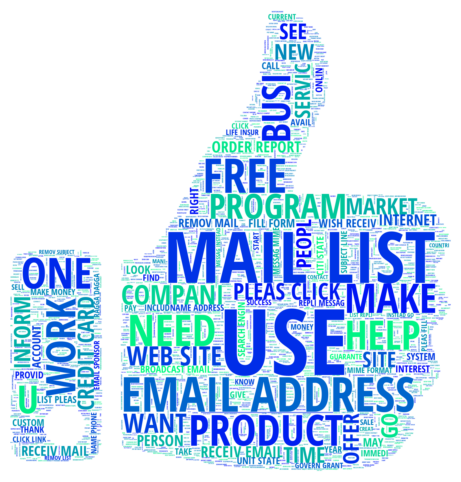

Wall time: 40.4 s


In [54]:
%%time
thumb_up_icon = Image.open(THUMB_UP_FILE)
image_mask = Image.new(mode='RGB', size=thumb_up_icon.size, color=(255, 255, 255))
image_mask.paste(thumb_up_icon, box=thumb_up_icon)
rgb_array = np.array(image_mask) # convert image mask to an array

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_words=2000, colormap='winter', font_path=FONT_FILE)
word_cloud.generate(' '.join(spam_words).upper())

plt.figure(figsize=(18, 6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

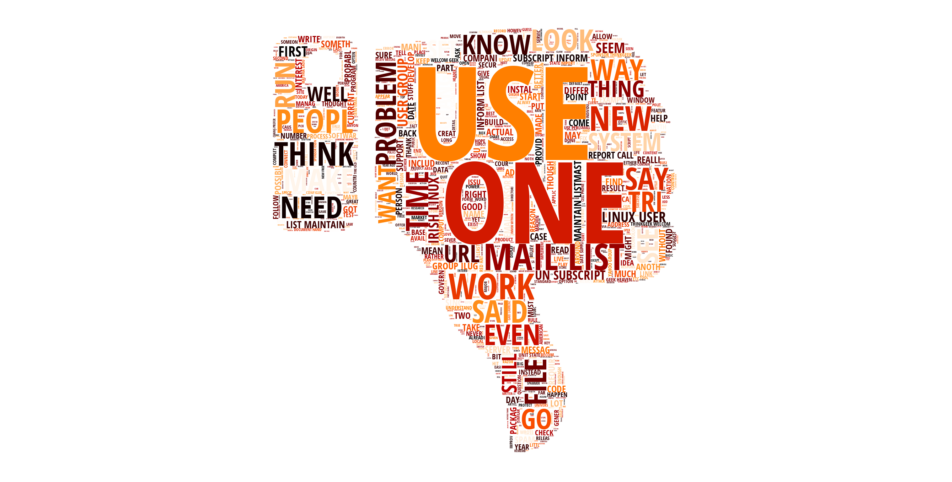

Wall time: 51.6 s


In [55]:
%%time
thumb_down_icon = Image.open(THUMB_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=thumb_down_icon.size, color=(255, 255, 255))
image_mask.paste(thumb_down_icon, box=thumb_down_icon)
rgb_array = np.array(image_mask) # convert image mask to an array

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_words=2000, colormap='gist_heat', font_path=FONT_FILE)
word_cloud.generate(' '.join(non_spam_words).upper())

plt.figure(figsize=(18, 6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#  Generate Vocabulary & Dictionary

In [56]:
flat_words = [word for subset in all_cleaned_emails for word in subset]
unique_words = pd.Series(flat_words).value_counts()
print(unique_words.shape[0])
unique_words.head()

27307


http     10626
use       5011
list      4830
email     4337
get       4199
dtype: int64

In [57]:
frequent_words = unique_words[0:VOCAB_NO]
frequent_words[:10]

http     10626
use       5011
list      4830
email     4337
get       4199
mail      3966
one       3901
free      3195
time      3036
work      2870
dtype: int64

## Creating Vocabulary Datafrrame with word_ids

In [58]:
word_ids = list(range(VOCAB_NO))

In [59]:
vocabulary = pd.DataFrame(data={'VOCAB_WORD': frequent_words.index}, index=word_ids)
vocabulary.index.name = 'WORD_ID'
vocabulary

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get
...,...
2495,inch
2496,filesystem
2497,fiction


## Saving Vocabulary as CSV

In [60]:
vocabulary.to_csv(WORD_VOCAB_FILE)

# Exercise

## Checking if a word exists in a vocabulary

In [61]:
# check these words individually
# app
# learn
# http
# teacher
# data
# science
'app' in set(vocabulary.VOCAB_WORD)

True

## Finding the longest email

In [62]:
all_cleaned_emails

DOC_ID
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, Length: 5796, dtype: object

In [63]:
length_of_emails = [len(email) for email in all_cleaned_emails]

largest = length_of_emails[0]
pos = 0
for x in length_of_emails:
    if x > largest:
        largest = x
        pos = length_of_emails.index(largest)

# using numpy to get the position
position = np.argmax(length_of_emails)
print('The position is: ', position)

The position is:  5775


In [64]:
print(max)
print(pos)

<built-in function max>
5775


In [65]:
' '.join(all_cleaned_emails[pos])

'yahoo group sponsor dvd free p join http new version unison avail test incorpor sever small improv main chang fix bug potenti seriou safeti consequ small number user habit run one instanc unison time parallel user strongli encourag upgrad other wait wish releas includ execut linux solari window look maintain moment none activ develop regularli use unison window machin configur properli build execut export grab http enjoy benjamin chang sinc ad prefer maxthread use limit number simultan file transfer ad backupdir prefer control backup file store basic support ad osx particular unison recogn one host synchron run osx switch treatment filenam consid file osx yet fulli work howev particular file resourc fork synchron correctli hash use form archiv name also ad name temp file creat file transfer reason updat detect go silent delet old temp file find along way want prevent delet temp file belong instanc unison may run parallel synchron differ host thank ruslan ermilov suggest sever small us

# Generating Features and a sparse matrix
## Creating Dataframe with one word per column

In [66]:
words_column_df = pd.DataFrame.from_records(list(all_cleaned_emails))
words_column_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


In [67]:
X_train, X_test,y_train, y_test = train_test_split(words_column_df, dataset.CATEGORY, test_size=0.3, random_state=42)

In [68]:
X_test.index.name = X_train.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,ye,inde,agent,directori,verita,cd,unix,subdirectori,file,call,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,harddissssk,like,alreadi,mount,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,origin,messag,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inlin,folk,sever,major,internet,outag,morn,across,major,provid,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicl,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [69]:
y_train.head()

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

## Creating a Sparse Matrix for Training Data

In [70]:
word_index = pd.Index(vocabulary.VOCAB_WORD)
word_index

Index(['http', 'use', 'list', 'email', 'get', 'mail', 'one', 'free', 'time',
       'work',
       ...
       'asian', 'bond', 'till', 'mutual', 'virginia', 'inch', 'filesystem',
       'fiction', 'khare', 'presenc'],
      dtype='object', name='VOCAB_WORD', length=2500)

In [71]:
word_index.get_loc('list')

2

In [72]:
def sparse_matrix(df, index_words, labels):
    """
    Retuns sparse matrix ad a Dataframe.
    
    df: Dataframe of words with document id as index (X_train or X_test).
    index_words: Index of words ordered with word id.
    labels: Category as a series (y_train or y_test)
    """
    no_rows = df.shape[0]
    no_colmns = df.shape[1]
    
    words_set = set(index_words)
    dict_list = []
    
    for i in range(no_rows):
        for j in range(no_colmns):
            word = df.iat[i, j]
            if word in words_set:
                doc_id = df.index[i]
                category = labels.at[doc_id]
                word_id = index_words.get_loc(word)
                
                item = {'CATEGORY': category, 'DOC_ID': doc_id, 'WORD_ID': word_id, 'OCCURENCE': 1}
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)
    
                    
    

In [73]:
%%time

sparse_train_df = sparse_matrix(X_train, word_index, y_train)

Wall time: 8min 11s


In [74]:
sparse_train_df.head()

,CATEGORY,DOC_ID,WORD_ID,OCCURENCE
0,0,4844,268,1
1,0,4844,1242,1
2,0,4844,504,1
3,0,4844,308,1
4,0,4844,253,1


In [75]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'CATEGORY']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID CATEGORY           
0      2       1                 1
       3       1                 1
       4       1                 1
       7       1                 3
       11      1                 1

In [76]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,CATEGORY,OCCURENCE
0,0,2,1,1
1,0,3,1,1
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


In [77]:
%%time

sparse_test_df = sparse_matrix(X_test, word_index, y_test)

Wall time: 3min 34s


In [78]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'CATEGORY']).sum()
test_grouped.head()

OCCURENCE
DOC_ID WORD_ID CATEGORY           
8      2       1                 1
       3       1                 4
       4       1                 2
       5       1                 1
       6       1                 2

In [79]:
test_grouped = test_grouped.reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,CATEGORY,OCCURENCE
0,8,2,1,1
1,8,3,1,4
2,8,4,1,2
3,8,5,1,1
4,8,6,1,2


## Saving train data and test data as txt file

In [80]:
np.savetxt(TRAIN_DATA_FILE, train_grouped, fmt='%d')
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'CATEGORY', 'OCCURENCE'], dtype='object')

In [81]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

# #######################-END-##################